<a href="https://colab.research.google.com/github/anaschougle32/DeepLearningCAP6619/blob/main/notebook63d395f321.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

import string
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , LSTM , Embedding
from keras.models import Sequential
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

import pickle

ModuleNotFoundError: No module named 'keras.preprocessing.text'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

import string
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

import tensorflow as tf
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , LSTM , Embedding
from keras.models import Sequential
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

import pickle

In [4]:
data = pd.read_csv("/kaggle/input/amazon-fine-food-reviews/Reviews.csv")
data.head()

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/amazon-fine-food-reviews/Reviews.csv'

In [6]:
data = pd.read_csv("/content/Reviews.csv")
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
data.shape

(568454, 10)

In [8]:
# Check null values
data.isna().sum().to_frame(name='# of missing values')

,# of missing values
Id,0
ProductId,0
UserId,0
ProfileName,26
HelpfulnessNumerator,0
HelpfulnessDenominator,0
Score,0
Time,0
Summary,27
Text,0


### Remove rows which are having null values

In [9]:
total_rows =  data.shape[0]
data.dropna(how='any',inplace=True)
remaining_rows= data.shape[0]

removed_rows = total_rows-remaining_rows
print("No. of rows removed :", removed_rows)

print(f"\nPercentage of data removed:{np.round((removed_rows/total_rows)*100,2)}%")
print(f"Percentage of data remaining:{np.round((remaining_rows/total_rows)*100,2)}%")

No. of rows removed : 53

Percentage of data removed:0.01%
Percentage of data remaining:99.99%


### Remove duplicate rows

In [10]:
a =  data.shape[0]
data.drop_duplicates(inplace=True, subset=['Score','Text'])
b = data.shape[0]

print("No. of rows removed :", a-b)

print(f"\nPercentage of data removed: {np.round(((a-b)/total_rows)*100,2)}%")
print(f"Percentage of data remaining: {np.round((b/total_rows)*100,2)}%")

No. of rows removed : 174745

Percentage of data removed: 30.74%
Percentage of data remaining: 69.25%


### Remove outliers

In [11]:
a =  data.shape[0]

idx = data[data["HelpfulnessNumerator"]>data["HelpfulnessDenominator"]].index
data.drop(index=idx, inplace=True)

b = data.shape[0]

print("No. of rows removed :", a-b)

print(f"\nPercentage of data removed:{np.round(((a-b)/total_rows)*100,2)}%")
print(f"Percentage of data remaining:{np.round((b/total_rows)*100,2)}%")

No. of rows removed : 2

Percentage of data removed:0.0%
Percentage of data remaining:69.25%


### Create target column using Score

In [12]:
## `Score` > 3 : "Positive"
## `Score` == 3 : "Neutral"
## `Score` < 3 : "Negative"

def create_target(x):

    return "Positive" if x>3 else "Negative" if x<3 else "Neutral"

data.loc[:, 'target'] = data.Score.apply(create_target)

In [13]:
# target column
data[['Score', 'target']].sample(5)

,Score,target
17245,5,Positive
152753,5,Positive
85986,5,Positive
386842,5,Positive
413380,5,Positive


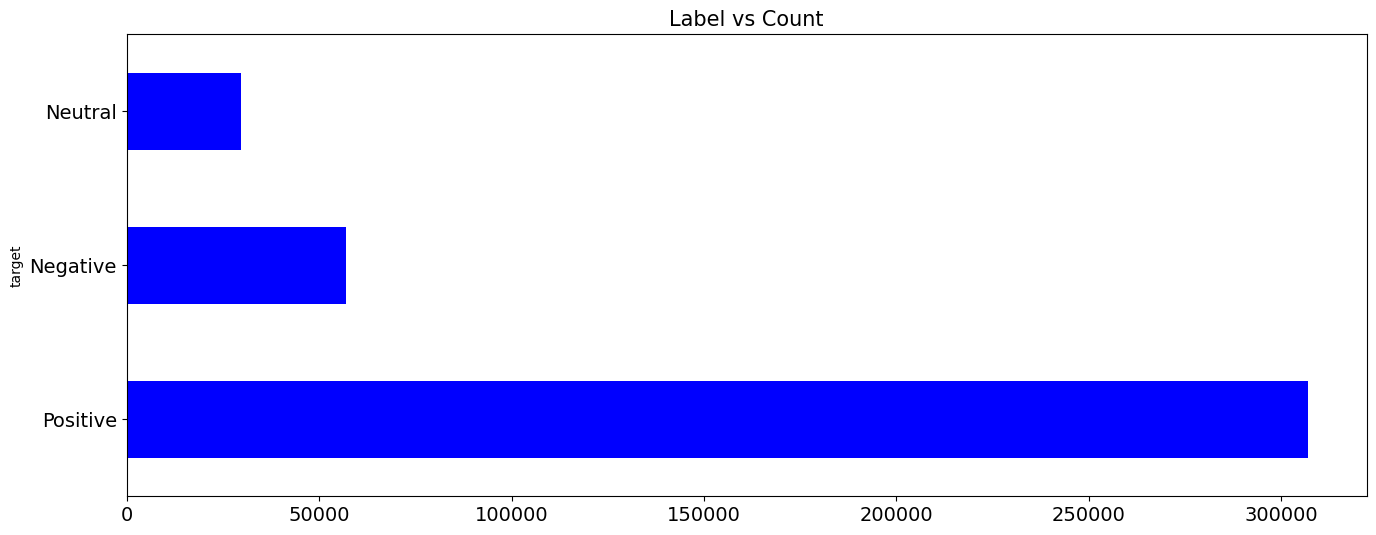

In [14]:
fig, ax = plt.subplots(figsize=(16, 6))

vc = data.target.value_counts()
vc.plot.barh(color="blue",fontsize=14,ax=ax)
ax.set_title("Label vs Count", fontsize=15)
plt.show()

### Down sampling (remove some positive and negative reviews)

In [15]:
neutral = data.loc[data.target=="Neutral"] # 29770 reviews

positive = data.loc[data.target=="Positive"].sample(50000)

negative = data.loc[data.target=="Negative"].sample(50000)

data = pd.concat([positive, negative, neutral])
data.shape

(129770, 11)

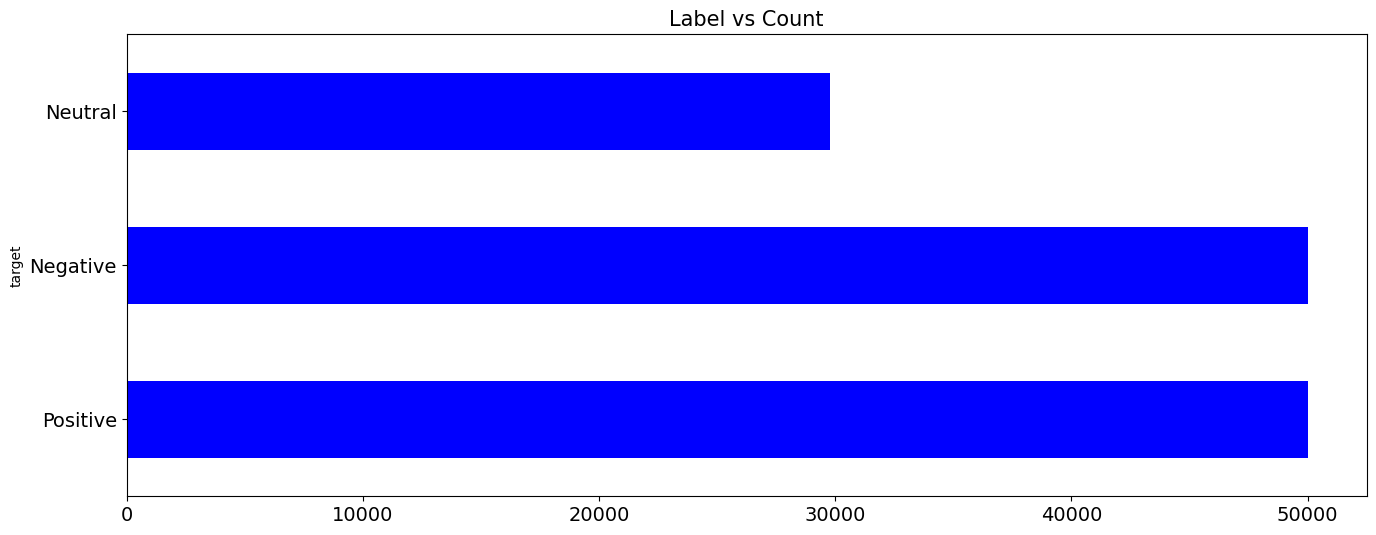

In [16]:
fig, ax = plt.subplots(figsize=(16, 6))

vc = data.target.value_counts()
vc.plot.barh(color="blue",fontsize=14,ax=ax)
ax.set_title("Label vs Count", fontsize=15)
plt.show()

### Target distribution (after)

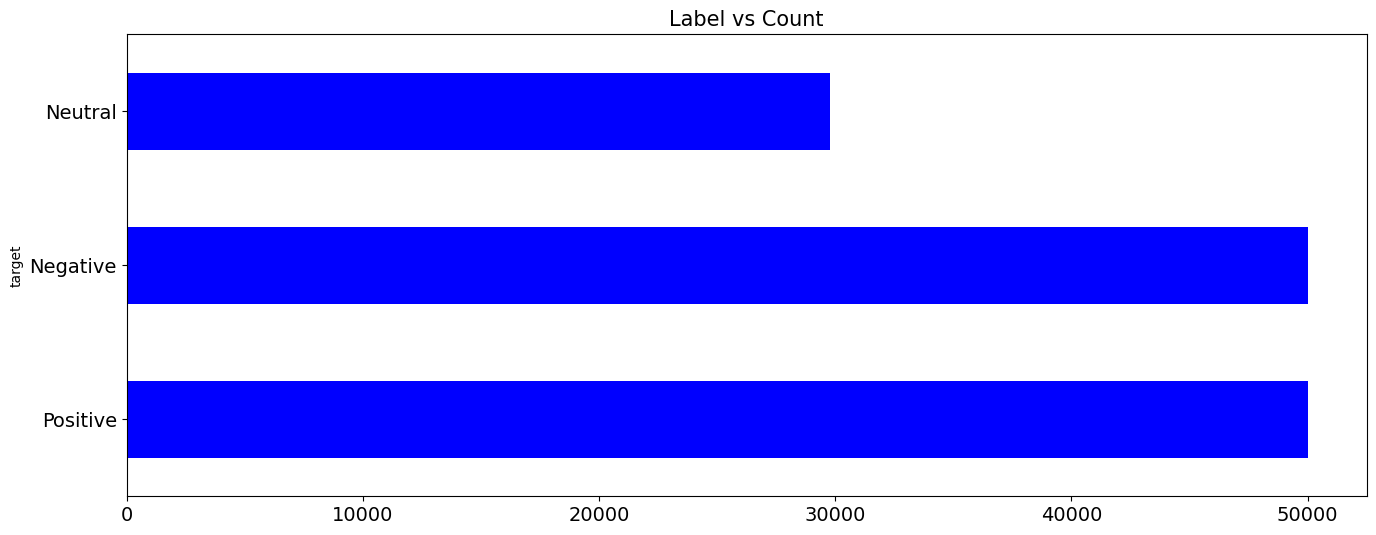

In [17]:
fig, ax = plt.subplots(figsize=(16, 6))

vc = data.target.value_counts()
vc.plot.barh(color="blue",fontsize=14,ax=ax)
ax.set_title("Label vs Count", fontsize=15)
plt.show()

### Stop words

In [19]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [20]:
# stopwords
total_stopwords = set(stopwords.words('english'))

# subtract negative stop words like no, not, don't etc.. from total_stopwords
negative_stop_words = set(word for word in total_stopwords
                          if "n't" in word or 'no' in word)

final_stopwords = total_stopwords - negative_stop_words

#
final_stopwords.add("one")
print(final_stopwords)

{'out', "i'd", 'mightn', 'your', "they'll", 'that', 'ours', 'after', 'd', 'hadn', 'y', 'both', 'those', 'under', 'my', 'so', 'once', "they've", 'weren', "we've", "she'll", 'i', 'ma', 'these', 'ourselves', 'them', "i'm", 'hasn', 'didn', 'through', 'have', "we're", "he's", 'o', 's', 'and', "it's", 'themselves', "it'll", 'any', 'where', 'couldn', 'an', 'mustn', 'do', 'each', 'needn', 'or', 'same', "we'll", 'hers', 'isn', 'as', 'down', 'who', 'all', 'when', 'was', 'most', 'their', 'one', 'can', 'having', 'there', 'then', 'wasn', 'few', 'am', 'because', 'by', 'but', "i'll", 'than', 'wouldn', 'her', 'before', 'from', 'should', 'whom', 'this', 'what', 'did', 'had', 'a', 'above', "he'd", 're', 'his', 'be', 'of', 'haven', 'how', "they're", 'over', 'more', 'himself', "you'd", 'until', 'about', 'll', 'against', 'they', 'he', 'herself', 'myself', "he'll", 'our', "she'd", "you've", "they'd", 'were', 'shan', "should've", 'which', 'the', "we'd", 'with', 'will', 'just', 'for', 'at', 'too', 'yourselves

### Remove unwanted words from reviews
#### Ex. html tags, punctuation, stop words, etc..

In [21]:
#stemming object
stemmer = PorterStemmer()

# ---------------------------------------------
HTMLTAGS = re.compile('<.*?>')
table = str.maketrans(dict.fromkeys(string.punctuation))
remove_digits = str.maketrans('', '', string.digits)
MULTIPLE_WHITESPACE = re.compile(r"\s+")
# ---------------------------------------------

In [22]:
def preprocessor(review):
    # remove html tags
    review = HTMLTAGS.sub(r'', review)

    # remove puncutuation
    review = review.translate(table)

    # remove digits
    review = review.translate(remove_digits)

    # lower case all letters
    review = review.lower()

    # replace multiple white spaces with single space
    review = MULTIPLE_WHITESPACE.sub(" ", review).strip()

    # remove stop words
    review = [word for word in review.split()
              if word not in final_stopwords]

    # stemming
    review = ' '.join([stemmer.stem(word) for word in review])

    return review

In [23]:
print("Before preprocessing : ")
data.Text.iloc[6]

Before preprocessing : 


"This sauce pump works adequately with the larger Torani sauce bottles.  I'm only giving four stars because I find it clogs pretty frequently with the Torani Mayan Chocolate sauce.  While this is probably more due to the nature of the sauce, it's still worth noting that if you do not use this every day, you'll likely have to clear clogs fairly often."

In [24]:
# apply preprocessing function

data.Text = data.Text.apply(preprocessor)
print("After preprocessing : ")
data.Text.iloc[6]

After preprocessing : 


'sauc pump work adequ larger torani sauc bottl im give four star find clog pretti frequent torani mayan chocol sauc probabl due natur sauc still worth note not use everi day youll like clear clog fairli often'

In [25]:
def generate_wcloud(text):
    stopwords = set(STOPWORDS)

    wordcloud = WordCloud(stopwords=stopwords, background_color='white')
    wordcloud.generate(text)

    plt.figure(figsize=(15,7))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation='bilinear')
    return plt.show()

### Word cloud for Positive reviews

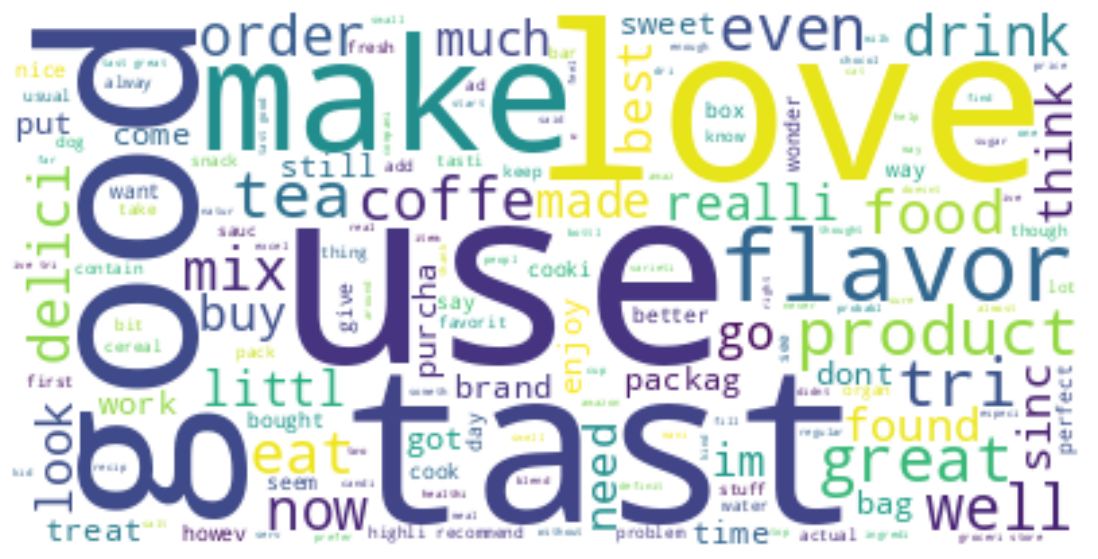

In [26]:
pos = data.loc[data.target=="Positive"].Text
text = " ".join(review for review in pos.astype(str))

generate_wcloud(text)

### Word cloud for Negative reviews

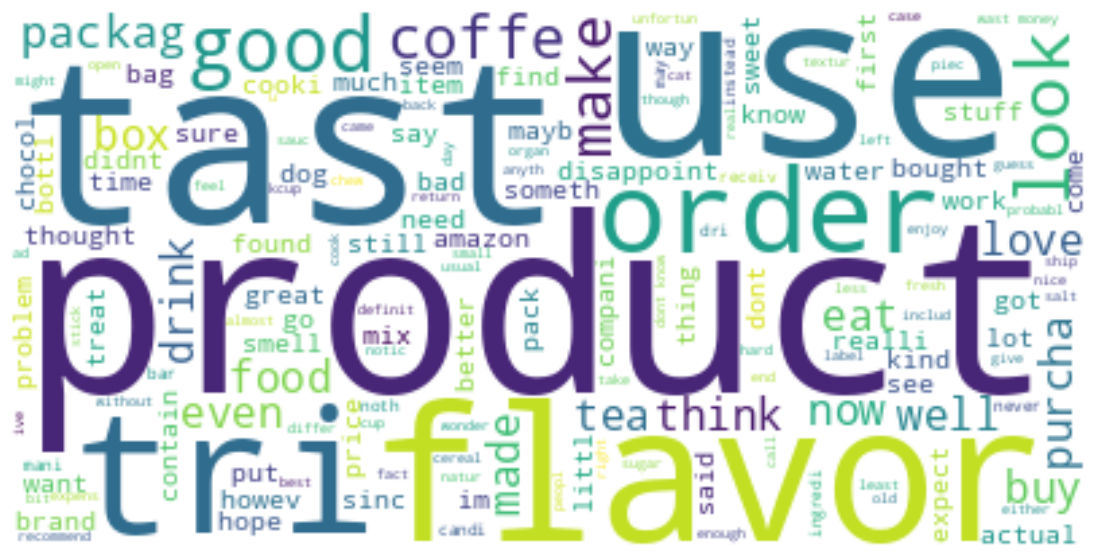

In [27]:
pos = data.loc[data.target=="Negative"].Text
text = " ".join(review for review in pos.astype(str))

generate_wcloud(text)

### Word cloud for Neutral reviews

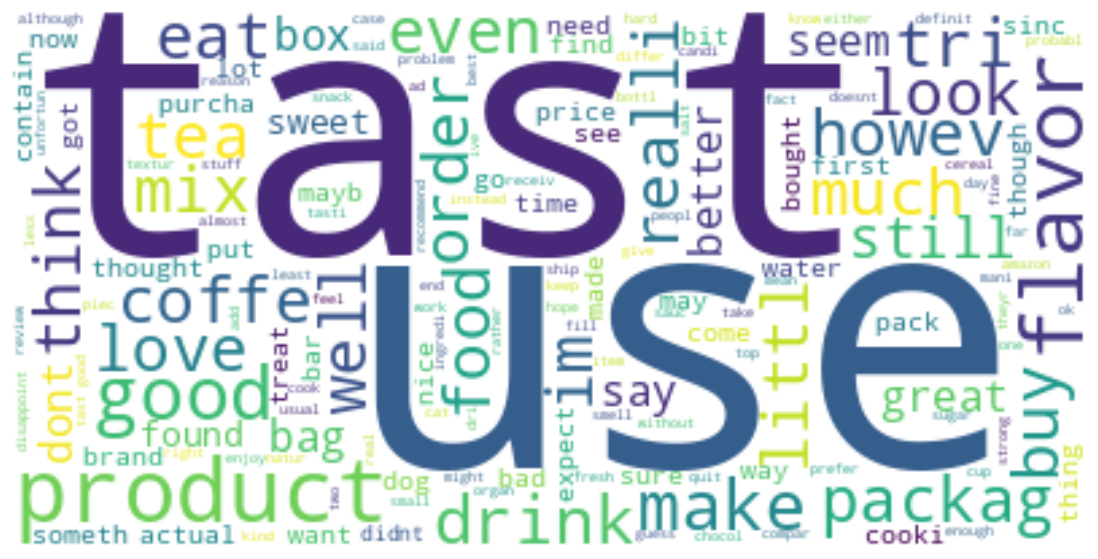

In [28]:
pos = data.loc[data.target=="Neutral"].Text
text = " ".join(review for review in pos.astype(str))

generate_wcloud(text)

<h2 style = "font-size:25px; font-family:Garamond ; font-weight : bold; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px">Train Test Split</h2>

#### Train set : 70% of data
#### Test set : 30% of data

In [29]:
X = data.Text
y = data.target

X_train, X_test, y_train, y_test = train_test_split(

    X, y, test_size=0.20, random_state=1, stratify=y)

In [30]:
X_train.shape, X_test.shape

((103816,), (25954,))

<h2 style = "font-size:25px; font-family:Garamond ; font-weight : bold; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px">Vectorization</h2>

### Bag of Words Vectorizer

In [31]:
bow_vectorizer = CountVectorizer(max_features=10000)
bow_vectorizer.fit(X_train)

# transform
bow_X_train = bow_vectorizer.transform(X_train)
bow_X_test = bow_vectorizer.transform(X_test)

### TF-IDF Vectorizer

In [32]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(X_train)

# transform
tfidf_X_train = tfidf_vectorizer.transform(X_train)
tfidf_X_test = tfidf_vectorizer.transform(X_test)

###  Label Encoding

In [33]:
labelEncoder = LabelEncoder()

y_train = labelEncoder.fit_transform(y_train)
y_test = labelEncoder.transform(y_test)

labels = labelEncoder.classes_.tolist()
print(labels) # index-> class

['Negative', 'Neutral', 'Positive']


<a id="4"></a>
<h2 style = "font-size:30px; font-family:Garamond ; font-weight : bold; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 10px">4. Model Training</h2>

In [34]:
###
def train_and_eval(model, trainX, trainY, testX, testY):

    # training
    _ = model.fit(trainX, trainY)

    # predictions
    y_preds_train = model.predict(trainX)
    y_preds_test = model.predict(testX)

    # evaluation
    print()
    print(model)
    print(f"Train accuracy score : {accuracy_score(y_train, y_preds_train)}")
    print(f"Test accuracy score : {accuracy_score(y_test, y_preds_test)}")
    print('\n',40*'-')

## Logistic Regression with BoW

In [36]:
# Hyperparameters
C = [0.001, 0.01, 0.1, 1, 10]

for c in C:
    # Define model
    log_model = LogisticRegression(C=c, max_iter=500, random_state=1)

    # Train and evaluate model
    train_and_eval(model=log_model,
                   trainX=bow_X_train,
                   trainY=y_train,
                   testX=bow_X_test,
                   testY=y_test)


LogisticRegression(C=0.001, max_iter=500, random_state=1)
Train accuracy score : 0.700508592124528
Test accuracy score : 0.6916467596516914

 ----------------------------------------

LogisticRegression(C=0.01, max_iter=500, random_state=1)
Train accuracy score : 0.7385374123449179
Test accuracy score : 0.7164213608692301

 ----------------------------------------

LogisticRegression(C=0.1, max_iter=500, random_state=1)
Train accuracy score : 0.7655852662402712
Test accuracy score : 0.7188102026662557

 ----------------------------------------

LogisticRegression(C=1, max_iter=500, random_state=1)
Train accuracy score : 0.7864587346844417
Test accuracy score : 0.7065192263234954

 ----------------------------------------

LogisticRegression(C=10, max_iter=500, random_state=1)
Train accuracy score : 0.7928546659474455
Test accuracy score : 0.6954612005856515

 ----------------------------------------


In [ ]:
# Hyperparameters
C = [0.001, 0.01, 0.1, 1, 10]

for c in C:
    # Define model
    log_model = LogisticRegression(C=c, max_iter=500, random_state=1)
    u
    # Train and evaluate model
    train_and_eval(model=log_model,
                   trainX=bow_X_train,
                   trainY=y_train,
                   testX=bow_X_test,
                   testY=y_test)

## Naive Bayes Classifier with BoW

In [37]:
alphas = [0, 0.2, 0.6, 0.8, 1]

for a  in alphas:
    # Define model
    nb_model = MultinomialNB(alpha=a)

    # Train and evaluate model
    train_and_eval(model=nb_model,
                   trainX=bow_X_train,
                   trainY=y_train,
                   testX=bow_X_test,
                   testY=y_test)


MultinomialNB(alpha=0)
Train accuracy score : 0.7110464668259228
Test accuracy score : 0.6848655313246513

 ----------------------------------------

MultinomialNB(alpha=0.2)
Train accuracy score : 0.7100735917392309
Test accuracy score : 0.6852508283886877

 ----------------------------------------

MultinomialNB(alpha=0.6)
Train accuracy score : 0.7098327810742082
Test accuracy score : 0.6857902442783386

 ----------------------------------------

MultinomialNB(alpha=0.8)
Train accuracy score : 0.7094956461431764
Test accuracy score : 0.686175541342375

 ----------------------------------------

MultinomialNB(alpha=1)
Train accuracy score : 0.7092933651845573
Test accuracy score : 0.6863681898743932

 ----------------------------------------


## Logistic Regression with Tf-Idf

In [38]:
# Hyperparameters
C = [0.001, 0.01, 0.1, 1, 10]

for c in C:
    # Define model
    log_model = LogisticRegression(C=c, max_iter=500, random_state=1)

    # Train and evaluate model
    train_and_eval(model=log_model,
                   trainX=tfidf_X_train,
                   trainY=y_train,
                   testX=tfidf_X_test,
                   testY=y_test)


LogisticRegression(C=0.001, max_iter=500, random_state=1)
Train accuracy score : 0.6445634584264468
Test accuracy score : 0.6432919781151267

 ----------------------------------------

LogisticRegression(C=0.01, max_iter=500, random_state=1)
Train accuracy score : 0.6792787238961239
Test accuracy score : 0.6743469214764584

 ----------------------------------------

LogisticRegression(C=0.1, max_iter=500, random_state=1)
Train accuracy score : 0.7319295676966941
Test accuracy score : 0.7166140094012483

 ----------------------------------------

LogisticRegression(C=1, max_iter=500, random_state=1)
Train accuracy score : 0.7632831162826539
Test accuracy score : 0.723125529783463

 ----------------------------------------

LogisticRegression(C=10, max_iter=500, random_state=1)
Train accuracy score : 0.7846478384834707
Test accuracy score : 0.7103721969638591

 ----------------------------------------


## Naive Bayes classifier with Tf-Idf

In [39]:
alphas = [0, 0.2, 0.6, 0.8, 1]

for a  in alphas:
    # Define model
    nb_model = MultinomialNB(alpha=a)

    # Train and evaluate model
    train_and_eval(model=nb_model,
                   trainX=tfidf_X_train,
                   trainY=y_train,
                   testX=tfidf_X_test,
                   testY=y_test)


MultinomialNB(alpha=0)
Train accuracy score : 0.7167873930800648
Test accuracy score : 0.6817060953995531

 ----------------------------------------

MultinomialNB(alpha=0.2)
Train accuracy score : 0.7153425290899283
Test accuracy score : 0.6833628727749095

 ----------------------------------------

MultinomialNB(alpha=0.6)
Train accuracy score : 0.7127706711874856
Test accuracy score : 0.6847499422054404

 ----------------------------------------

MultinomialNB(alpha=0.8)
Train accuracy score : 0.7116340448485783
Test accuracy score : 0.6848655313246513

 ----------------------------------------

MultinomialNB(alpha=1)
Train accuracy score : 0.7099098404870154
Test accuracy score : 0.6842875857285967

 ----------------------------------------


<a id="5"></a>
<h2 style = "font-size:30px; font-family:Garamond ; font-weight : bold; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 10px">5. Model Evaluation</h2>

In [40]:
def plot_cm(y_true, y_pred):
    plt.figure(figsize=(6,6))

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    sns.heatmap(
        cm, annot=True, cmap='Blues', cbar=False, fmt='.2f',
        xticklabels=labels, yticklabels=labels)

    return plt.show()

### Best model : Logistic Regression(C=1) with TfIdf data

In [41]:
bmodel = LogisticRegression(C=1, max_iter=500, random_state=1)
bmodel.fit(tfidf_X_train, y_train)

LogisticRegression(C=1, max_iter=500, random_state=1)

In [42]:
# predictions
y_preds_train = bmodel.predict(tfidf_X_train)
y_preds_test = bmodel.predict(tfidf_X_test)

### Accuracy

In [43]:
print(f"Train accuracy score : {accuracy_score(y_train, y_preds_train)}")
print(f"Test accuracy score : {accuracy_score(y_test, y_preds_test)}")

Train accuracy score : 0.7632831162826539
Test accuracy score : 0.723125529783463


### Confusion Matrix

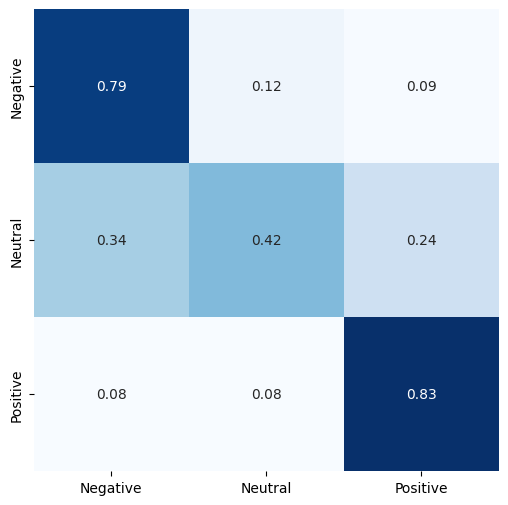

In [44]:
plot_cm(y_test, y_preds_test)

### Observations

#### - Our model is performing better on classifying positive and negative reviews.
#### - Need improvement in classifying the neutral reviews (Any suggestions??)

<a id="6"></a>
<h2 style = "font-size:30px; font-family:Garamond ; font-weight : bold; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 10px">6. Deployment</h2>

### Save model and transformer

In [45]:
with open("transformer.pkl", "wb") as f:
    pickle.dump(tfidf_vectorizer, f)

with open("model.pkl", "wb") as f:
    pickle.dump(bmodel, f)

### Prediction on single review

In [48]:
# labels = ['Negative', 'Neutral', 'Positive']
def get_sentiment(review):
    # preprocessing
    x = preprocessor(review)
    #vectorization
    x = tfidf_vectorizer.transform([x])
    #prediction
    y = int(bmodel.predict(x.reshape(1,-1)))
    return labels[y]

In [46]:
# labels = ['Negative', 'Neutral', 'Positive']
def get_sentiment(review):
    # preprocessing
    x = preprocessor(review)1q1
    #vectorization
    x = tfidf_vectorizer.transform([x])
    #prediction
    y = int(bmodel.predict(x.reshape(1,-1)))
    return labels[y]

SyntaxError: invalid decimal literal (<ipython-input-46-74be2d6397c7>, line 4)

In [49]:
# positve review
review = "This chips packet is very tasty. I highly recommend this!"
print(f"This is a {get_sentiment(review)} review!")

This is a Positive review!


In [50]:
# positve review
review = "This product is a waste of money. Don't buy this!!"
print(f"This is a {get_sentiment(review)} review!")

This is a Negative review!


## Next steps..

### Web app and Deployment code will be updated soon on my github

#### Link: https://github.com/ashok49473/reviews-sentiment-classifier

## References
---

#### Theory : https://www.pyoneer.io/post/5-reasons-why-sentiment-analysis-is-important

#### CSS styling: https://www.kaggle.com/bhuvanchennoju/ancient-roots-of-agriculture-a-data-overview

#### word cloud : https://re-thought.com/creating-wordclouds-in-python/

#### Keras :  https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

